# Explore here

In [46]:
# importamos bobliotecas necesarias
import pandas as pd
import numpy as np
import eda_functions as ed
# Modelos , division de datos, escalado y metricas
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler


In [47]:
# importar el dataframe
path = 'https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv'

df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv')

In [48]:
# Mostramos estructura del dataframe
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [49]:
# Informacion del dataframe
ed.df_info(df)

,nunique,nulls,percent_nulls,Dtype,non_null,total_values
age,47,0,0.0,int64,1338,1338
sex,2,0,0.0,object,1338,1338
bmi,548,0,0.0,float64,1338,1338
children,6,0,0.0,int64,1338,1338
smoker,2,0,0.0,object,1338,1338
region,4,0,0.0,object,1338,1338
charges,1337,0,0.0,float64,1338,1338


Dtype
object     3
int64      2
float64    2
Name: count, dtype: int64

El dataframe tiene 1338 filas y 7 columnas
Hay 1 valores duplicados


In [50]:
# Eliminamos el Duplicado
df = df.drop_duplicates()

Las columnas sex y smoker se convertiran en binarias {0, 1} facilmente.

Con la columna region se usara target encoding

In [51]:
# codificamos las columnas binarias
df['smoker_label'] = df['smoker'].apply(lambda x: 0 if x == 'no' else 1)
df['gender_label'] = df['sex'].apply(lambda x: 0 if x == 'male' else 1)

In [52]:
# Codificacion target encoding de la columna region en base a charges (ver eda_functions.py)
df = ed.target_encoding(df, 'region', 'charges', smooth_coef=0)

In [53]:
# Lsita de columnas a graficar
columns_list = ['age', 'bmi', 'children','smoker_label', 'gender_label']

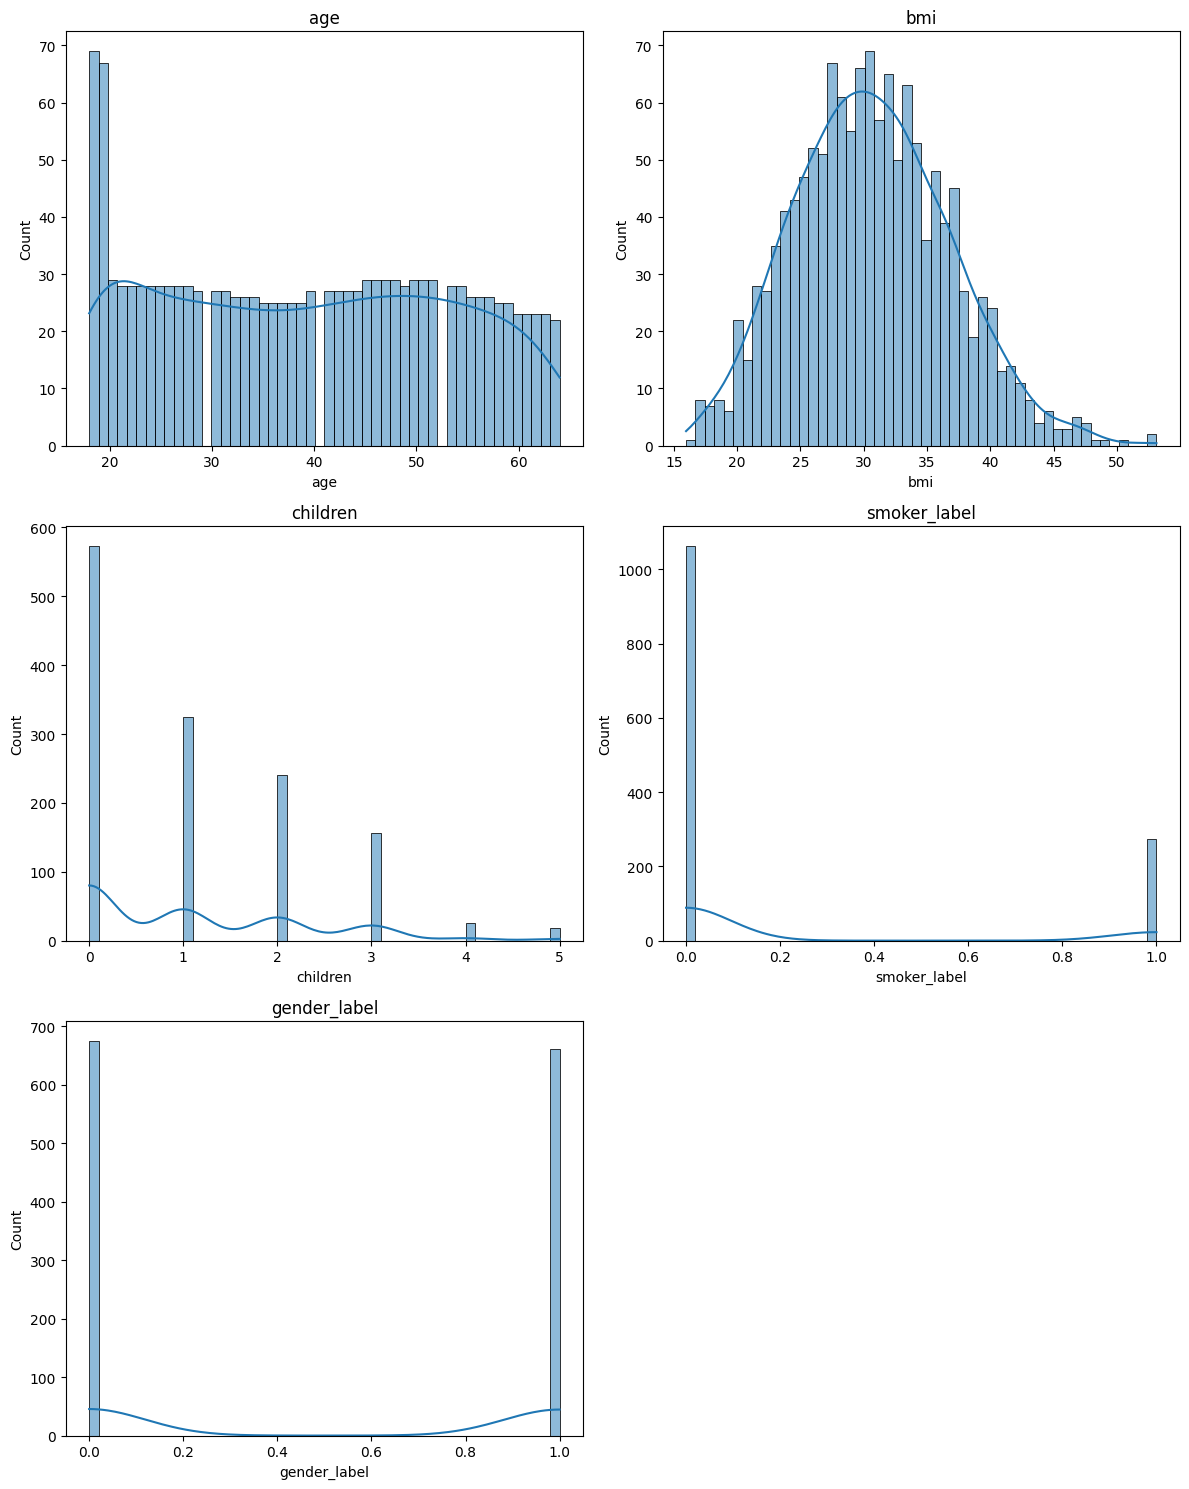

In [54]:
# Llamamos a la funcion para graficar multiples variables (ver eda_functions.py)
ed.multi_histplot(df, columns_list,n_rows=3, n_cols=2, fig_size=(12, 15))

ANALISIS DE LAS GRAFICAS|
--

- Se aprecia un pico de alta frecuencia para la edades por debajo de 20 años
- Distribución del BMI bastante regular con media en torno a 25-35 y ligero sesgo a derecha indicando que hay casos de obesidad severa
- El numero de no fumadores dobla aproximadamente al de fumadores. Si bien en un modelo de regresion lineal no es tan relevante, en otro tipo de modelos habria que contemplar un balanceo de clases
- La variable genero esta balanceada, habiendo practicamente el mismo numero de hombres que de mujeres en los datos.
- La variable region tambien esta balanceada con una ligera predominancia de southeast

In [55]:
columns_list = ['age', 'bmi', 'children','charges']

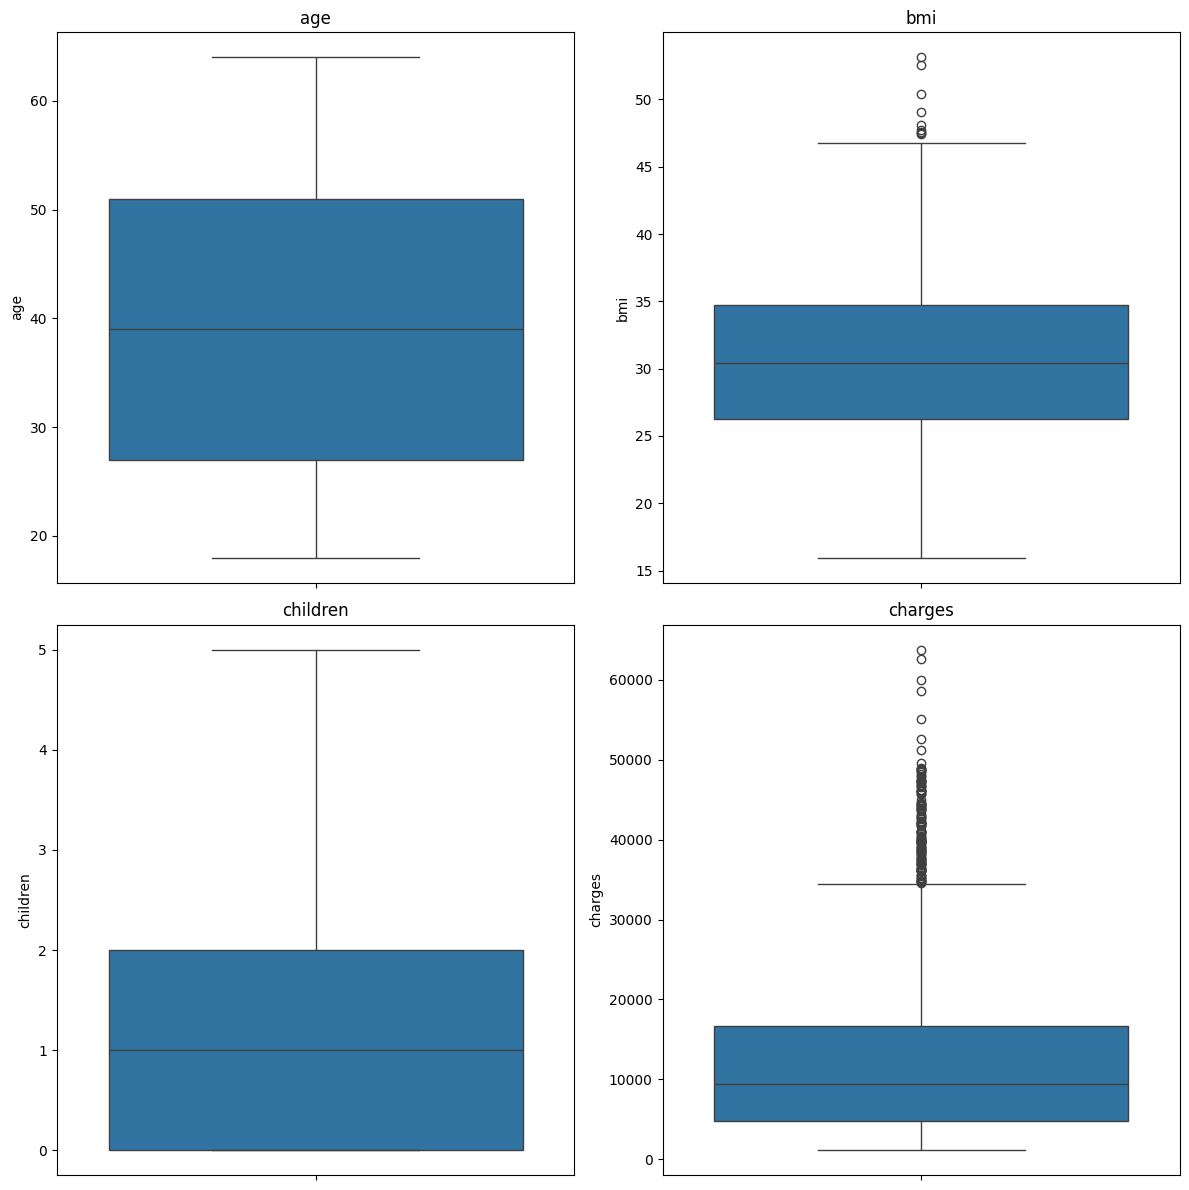

In [56]:
# Graficos boxplot para apreciar posibles outliers (ver eda_functions.py)
ed.multi_boxplot(df, columns_list, 2, 2, fig_size=(12, 12))

ANALISIS DE LAS GRAFICAS|
--

- Variable age: Bien distribuida sin outliers visibles y con una media en torno a los 40 años
- Distribución del BMI con una media en torno a 30 y , como se intuia por el sesgo a derecha en el histograma, algunos outliers por encima de 45
- La media de hijos de la muestra esta en 1 y la mayoria seetan en torno a 0 y dos hijos
- E la columna objetivo se aprecian multiples outliers a partir de los 35000 dolares

In [57]:
# Lectura de las columnas del dataframe
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'smoker_label', 'gender_label', 'encoded_region'],
      dtype='object')

In [58]:
# Filtramos las columnas a usar
df = df[['age','bmi', 'children','charges',
       'smoker_label', 'gender_label']]

In [59]:
# Dividir datos en train y test
X_train, X_test, y_train, y_test = train_test_split(df.drop('charges', axis=1), df['charges'], test_size=0.2)

In [60]:
# Ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir los valores para el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular las métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mostrar las métricas
print(f"R-squared (R²): {r2}")
print('--------------------------')
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f'mean_absolute_percentage_error(MAPE): {mape}')


R-squared (R²): 0.6954334017089001
--------------------------
Mean Absolute Error (MAE): 4451.004566001754
Mean Squared Error (MSE): 41712373.28793528
mean_absolute_percentage_error(MAPE): 0.3723721241870162


OBSERVACIONES SOBRE LAS METRICAS|
--

Estas métricas indican que tu el tiene una capacidad razonablemente buena de predecir los valores, dada la R² de aproximadamente 0.787, pero también hay un error significativo en las predicciones (como se refleja en el MAE, MSE y MAPE).

---

OPTIMIZACION DEL MODELO|
--

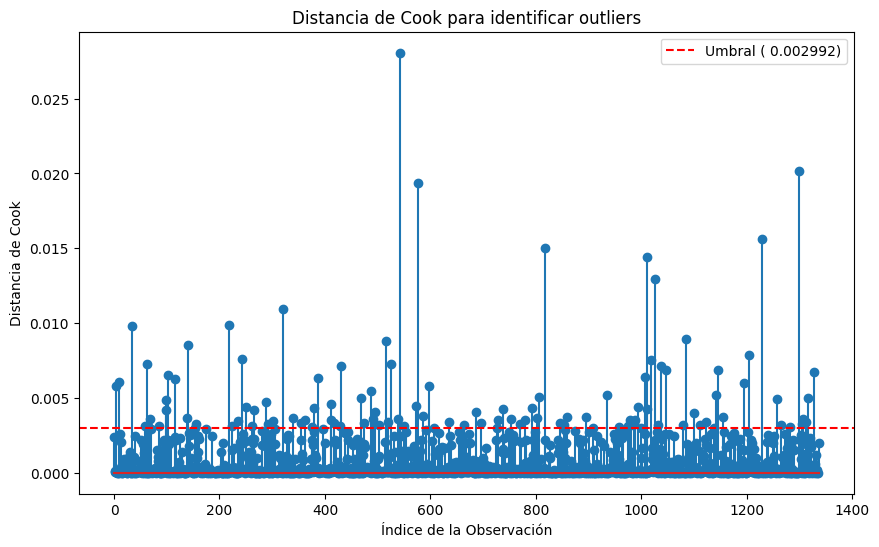

In [61]:
# Busqueda de outliers con distaqncia de cook
import statsmodels.api as sm

# Suponiendo que df es tu DataFrame
X = df[['age', 'bmi', 'children', 'smoker_label', 'gender_label']]  # Características
y = df['charges']  # Variable objetivo

# Agregar una constante a X para el término intercepto
X = sm.add_constant(X)

# Ajustar el modelo de regresión lineal
model = sm.OLS(y, X).fit()

# Obtener las medidas de influencia
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

# Graficar las distancias de Cook para visualizar puntos influyentes
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.stem(cooks_d)
plt.title('Distancia de Cook para identificar outliers')
plt.xlabel('Índice de la Observación')
plt.ylabel('Distancia de Cook')
# Umbral para la distancia de cook
limite_cook = 4 / len(X)
# Mostrar en el grafico linea horizontal punteada con el umbral
plt.axhline(y=limite_cook, color='red', linestyle='--', label=f'Umbral ({limite_cook: .6f})')
plt.legend()
plt.show()



In [62]:
# Definimos los indices que estan porn encima del umbral definido
outlier_indices = np.where(cooks_d > limite_cook)[0]

# Mostrar los índices de los outliers
print("Índices de outliers según la distancia de Cook:", outlier_indices)


Índices de outliers según la distancia de Cook: [   3    9   34   58   62   64   69   85   98   99  102  115  138  140
  153  156  219  224  235  242  250  262  266  289  292  301  321  340
  355  362  376  380  387  411  412  417  429  430  468  474  488  491
  494  502  516  520  526  539  543  549  573  577  586  598  636  663
  687  695  729  738  753  769  779  792  802  805  818  846  853  859
  895  908  935  958  974  979  981  986  988  993 1007 1010 1011 1018
 1026 1032 1038 1046 1079 1084 1099 1111 1123 1138 1141 1145 1155 1194
 1205 1229 1257 1264 1281 1299 1305 1306 1313 1316 1327]


In [70]:
# Eliminar outliers de los datos
X_clean = X.drop(index=outlier_indices)
y_clean = y.drop(index=outlier_indices)
X_clean.drop('const', axis=1, inplace=True)

---

UNA VEZ ELIMINADOS LOS OUTLIERS, REINSTANCIAMOS Y REENTRENAMOS EL MODELO 

In [72]:
# Dividir los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2)

# Ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir los valores para el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular las métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mostrar las métricas
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f'mean_absolute_percentage_error(MAPE): {mape}')
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 3020.1175677056303
Mean Squared Error (MSE): 21797971.808695443
mean_absolute_percentage_error(MAPE): 0.2935592514384463
R-squared (R²): 0.8487958888052525


La eliminación de outliers parece haber tenido un impacto positivo en todas las métricas.

El modelo es ahora más robusto y proporciona estimaciones más precisas. 

---

SEGUNDA PRUEBA DE OPTIMIZACION CON UN MODELO REGULARIZADO Y ESCALADO DE LAS CARACTERISTICAS|
--

In [73]:
X_train

,age,bmi,children,smoker_label,gender_label
887,22,39.500,0,0,0
125,26,28.785,0,0,1
1058,32,33.820,1,0,0
132,53,35.900,2,0,1
350,57,23.180,0,0,1
...,...,...,...,...,...
42,41,21.780,1,0,0
867,61,23.655,0,0,0
475,61,28.310,1,1,0
404,31,20.400,0,0,0


In [74]:
# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo con regularización
model = LassoCV(cv=50).fit(X_train_scaled, y_train)
print("Mejor valor de alpha:", model.alpha_)

# Predicción y evaluación
y_pred = model.predict(X_test_scaled)
# Calcular las métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('--------------------------')
# Mostrar las métricas
print(f"R-squared (R²): {r2}")
print('--------------------------')
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f'mean_absolute_percentage_error(MAPE): {mape}')

Mejor valor de alpha: 50.779480519778595
--------------------------
R-squared (R²): 0.8485603120581813
--------------------------
Mean Absolute Error (MAE): 3009.6122685584464
Mean Squared Error (MSE): 21831933.155717462
mean_absolute_percentage_error(MAPE): 0.28885663808617035


Se observa una ligera mejoria en las metricas con el uso de un modelo regularizado  sin impactar en la complejidad del modelo.

---

In [75]:
from joblib import dump

# Exportar modelo
dump(model, 'modelo_regresion_lineal.joblib')


['modelo_regresion_lineal.joblib']

CONCLUSION|
--

Esta practica me ha permitido constatar como una correcta optimizacion del modelo puede mejorar significativamente su desempeño y su robustez. Aspecto clave es el EDA que , si bien es el que menos me llama la atención , tambien es la base para un modelo eficaz